## Utilities

In [3]:
%run ../common_functions.py

read_dataset()
read_all_datasets()
read_processed_data()
combine_text_columns()
split_train_test()
extract_data()
evaluate_model()
detect_missing_values()


## Imports

In [4]:
import yaml
import pandas as pd
from tqdm.auto import tqdm
from random import choice
import os
from sklearn.model_selection import train_test_split

In [5]:
from data_preprocessing.text_cleaning import (
    remove_html,
    remove_urls,
    remove_digits,
    remove_punctuation,
    remove_special_characters,
    normalize_whitespace,
    to_lowercase
)
from data_preprocessing.add_domain import add_domain
from data_preprocessing.find_and_remove_duplicates import find_and_remove_dups
from data_preprocessing.balance_data import balance_data, augmentation_threshold

In [6]:
from data_augmentation.paraphrasing import paraphrase
from data_augmentation.style_transfer import transfer_style

In [7]:
from constants import DATASETS

## Load config

In [8]:
with open("config.yml", "r") as f:
    config = yaml.safe_load(f)

## Setup output folder

In [9]:
if not os.path.isdir(config["output"]):
    os.mkdir(config["output"])

## Load Data

In [12]:
data = read_all_datasets().sample(n=5000)

# -- Orchestration --

## Data Preprocessing

### Find and Remove duplicate Data

In [11]:
datasets = {dataset: read_dataset(dataset) for dataset in DATASETS}
data = find_and_remove_dups(data, datasets)

Total rows                 : 5000
Unique 'text' entries      : 4993
Duplicate 'text' entries   : 7 (0.14% of total)


==DUPLICATES WITHIN DATASET==
  • Climate-FEVER: 0 duplicates removed, rows 1535→1535 (-0.00%)
  • Fake News Corpus: 7335 duplicates removed, rows 70846→63511 (-10.35%)
  • Fakeddit: 40 duplicates removed, rows 7000→6960 (-0.57%)
  • FakeNewsNet: 1472 duplicates removed, rows 23196→21724 (-6.35%)
  • FEVER: 7518 duplicates removed, rows 109810→102292 (-6.85%)


KeyboardInterrupt: 

### Domain Tagging

Computing sentence embeddings...
Using device >> mps


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Initializing KMeans with k=13 Clusters...
Predicting domains with KMeans...
Mapping domain IDs to topic names...
Plotting...


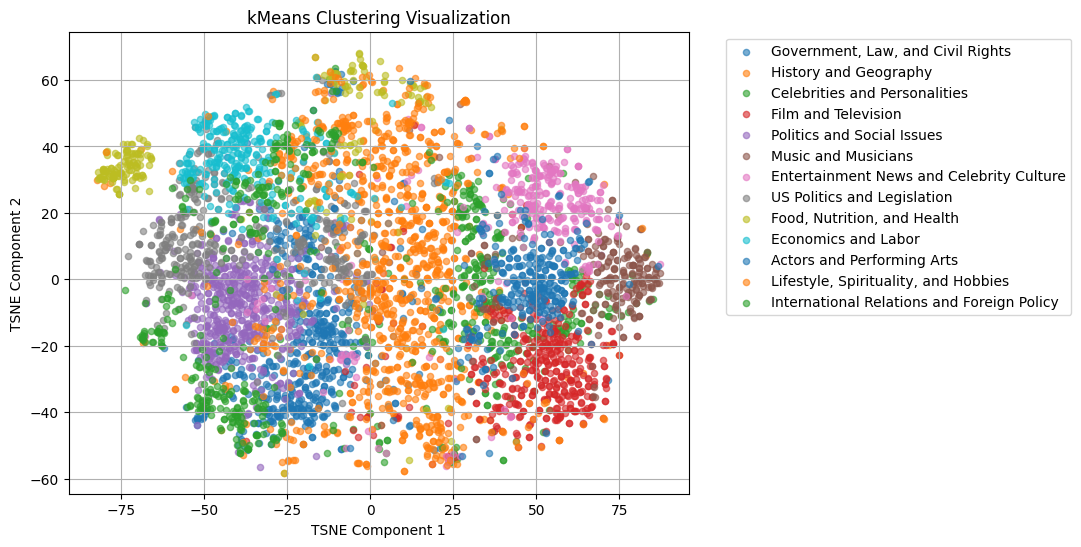



Topic Distribution: domain
Lifestyle, Spirituality, and Hobbies          580
Politics and Social Issues                    555
Government, Law, and Civil Rights             495
History and Geography                         465
Film and Television                           440
US Politics and Legislation                   397
Celebrities and Personalities                 361
International Relations and Foreign Policy    337
Entertainment News and Celebrity Culture      327
Actors and Performing Arts                    307
Economics and Labor                           296
Music and Musicians                           225
Food, Nutrition, and Health                   215
Name: count, dtype: int64


In [13]:
data = add_domain(data, 
                  k=config["domain_tagging"]["n_domains"],
                  tokenizer_model = config["tokenization"]["tokenizer_model"],
                  save_embeddings=config["domain_tagging"]["save_embeddings"], 
                  use_saved_embeddings=config["domain_tagging"]["use_saved_embeddings"],
                  plot_kmeans=config["domain_tagging"]["plot"])

## Data Augmentation

### Paraphrasing

In [37]:
if config["augmentation"]["paraphrasing"]["enabled"]:
    samples_to_augment = augmentation_threshold(data, config["augmentation"]["augmentation_budget"])

    for domain, n_samples in samples_to_augment.items():
        if n_samples == 0:
            continue

        augmented_texts = []
        df_domain = data[data["domain"] == domain]
        n = min(n_samples, len(df_domain))
        df_domain = df_domain.sample(n=n).copy()

        print(f"Paraphrasing {n} datapoints from domain {domain}...")
        augmented_texts = [paraphrase(text) for text in tqdm(df_domain["text"], desc=f"Paraphrasing {domain}", leave=False)]
        
        df_domain["text"] = augmented_texts

        data = pd.concat([data, df_domain], ignore_index=True)

Paraphrasing 2 datapoints from domain US Policy & Legislation...
Paraphrasing 6 datapoints from domain Entertainment & Media...
Paraphrasing 12 datapoints from domain Celebrity News & Royalty...
Paraphrasing 80 datapoints from domain Social Issues & Culture Wars...


### Style Transfer

In [14]:
if config["augmentation"]["style_transfer"]["enabled"]:
    samples_to_augment = augmentation_threshold(data, config["augmentation"]["augmentation_budget"])

    target_styles = [
        "Neutral journalistic",
        "Slightly formal",
        "Slightly informal",
        "Objective report",
        "Simplified for general audience",
        "Summarized headline-style",
        "Explanatory tone",
        "Skeptical tone",
        "Curious/inquisitive tone"]

    for domain, n_samples in samples_to_augment.items():
        if n_samples == 0:
            continue

        augmented_texts = []
        df_domain = data[data["domain"] == domain]
        n = min(n_samples, len(df_domain))
        df_domain = df_domain.sample(n=n).copy()

        print(f"Transfering style for {n} datapoints from domain {domain}...")
        augmented_texts = [transfer_style(text, choice(target_styles)) for text in tqdm(df_domain["text"], desc=f"Style Transfer for {domain}", leave=False)]

        df_domain["text"] = augmented_texts

        data = pd.concat([data, df_domain], ignore_index=True)

Transfering style for 10 datapoints from domain Food, Nutrition, and Health...


## Data Preprocessing

### Text Cleaning

In [14]:
def clean_text(text, config):
    if config["strip_html"]:
        text = remove_html(text)
    if config["remove_urls"]:
        text = remove_urls(text)
    if config["remove_digits"]:
        text = remove_digits(text)
    if config["remove_punctuation"]:
        text = remove_punctuation(text)
    if config["remove_special_chars"]:
        text = remove_special_characters(text)
    if config["lowercase"]:
        text = to_lowercase(text)
    if config["normalize_whitespace"]:
        text = normalize_whitespace(text)
    
    return text

In [15]:
data["text"] = data["text"].apply(lambda x: clean_text(x, config["preprocessing"]))

### Balancing domain and label

In [15]:
if config["balance_data"]["balance"]:
    data = balance_data(data, tolerance=config["balance_data"]["balance_tolerance"])

Balancing every domain to approx. 337 datapoints
Max. difference in assigned rows to domain was 355 rows and is now 112 rows
Label imbalance (0 vs. 1) was 56.1% vs. 43.9% and is now 57.4% vs. 42.6%


## Save Output

In [17]:
data['stratify_key'] = data['label'].astype(str) + "_" + data['domain'].astype(str)


train_val_data, test_data = train_test_split(data, test_size=config["test_size"], stratify=data['stratify_key'])

train_val_data.drop(columns='stratify_key', inplace=True)
test_data.drop(columns='stratify_key', inplace=True)

train_val_data = train_val_data.sample(frac=1.0).reset_index(drop=True)
test_data = test_data.sample(frac=1.0).reset_index(drop=True)

In [20]:
augmented = any([config["augmentation"]["synonym_replacement"]["enabled"],
                config["augmentation"]["paraphrasing"]["enabled"],
                config["augmentation"]["style_transfer"]["enabled"]])

balanced = config["balance_data"]["balance"]

folder_name = {
    (False, False): 'raw',
    (True,  False): 'balanced',
    (False, True):  'augmented',
    (True,  True):  'balanced_augmented'
}[(balanced, augmented)]

folder_path = os.path.join(config['output'], folder_name)

if not os.path.isdir(folder_path):
    os.mkdir(folder_path)

train_val_data.to_parquet(f"{folder_path}/preprocessed_data_train_val.parquet", index=False)
test_data.to_parquet(f"{folder_path}/preprocessed_data_test.parquet", index=False)